<a href="https://colab.research.google.com/github/dksifoua/Face-Mask-Detector/blob/main/Face%20Mask%20Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/dksifoua/Face-Mask-Detector.git

Cloning into 'Face-Mask-Detector'...
remote: Enumerating objects: 1313, done.
remote: Counting objects: 100% (1313/1313), done.
remote: Compressing objects: 100% (1309/1309), done.
remote: Total 1313 (delta 9), reused 1291 (delta 1), pack-reused 0
Receiving objects: 100% (1313/1313), 48.49 MiB | 20.59 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
import os
os.getcwd()

'/content'

In [3]:
os.chdir('./Face-Mask-Detector/')
os.getcwd()

'/content/Face-Mask-Detector'

In [4]:
!nvidia-smi

Wed Nov  4 14:08:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load dependencies

In [5]:
# !pip install wget

In [6]:
import os
import cv2
import tqdm
import argparse
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [7]:
%matplotlib inline

SEED = 456
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Train Mask Classifier

***Prepare data***

In [8]:
data, labels = [], []
for label in os.listdir('./data'):
    image_path = os.path.join('./data', label)
    for image_filename in tqdm.tqdm(os.listdir(image_path)):
        image = tf.keras.preprocessing.image.load_img(os.path.join(image_path, image_filename),
                                                      target_size=(224, 224))
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
        data.append(image)
        labels.append(label)

data = np.array(data, dtype='float32')
labels = np.array(labels)
print(f'Data shape: {data.shape}')
print(f'Labels shape: {labels.shape}')

100%|██████████| 686/686 [00:02<00:00, 331.71it/s]


Data shape: (1376, 224, 224, 3)
Labels shape: (1376,)


In [9]:
binarizer = LabelBinarizer()
labels = binarizer.fit_transform(labels)

***Train test split***

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_test shape: {Y_test.shape}')

X_train shape: (1100, 224, 224, 3)
X_test shape: (276, 224, 224, 3)
Y_train shape: (1100, 1)
Y_test shape: (276, 1)


***Build the classifier***

In [11]:
def get_model(freeze=True):
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet',
        include_top=False, input_shape=(224, 224, 3))
    if freeze:
        for layer in base_model.layers:
            layer.trainable = False
    
    head_model = base_model.output
    head_model = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(head_model)
    head_model = tf.keras.layers.Flatten()(head_model)
    head_model = tf.keras.layers.Dense(128, activation=tf.nn.relu)(head_model)
    head_model = tf.keras.layers.Dropout(0.5)(head_model)
    head_model = tf.keras.layers.Dense(1, activation='sigmoid')(head_model)
    
    model = tf.keras.Model(inputs=base_model.input, outputs=head_model)
    
    return model


model = get_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

9412608/9406464 [==============================] - 0s 0us/step


***Data generator***

In [12]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest')

***Fit the model***

In [13]:
history = model.fit(generator.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    validation_data=(X_test, Y_test),
    validation_steps=len(X_test) // 32,
    epochs=5)

Epoch 1/5
34/34 [==============================] - 12s 342ms/step - loss: 0.1049 - accuracy: 0.9625 - val_loss: 0.0312 - val_accuracy: 0.9855
Epoch 2/5
34/34 [==============================] - 11s 313ms/step - loss: 0.0206 - accuracy: 0.9916 - val_loss: 0.0066 - val_accuracy: 0.9964
Epoch 3/5
34/34 [==============================] - 11s 314ms/step - loss: 0.0123 - accuracy: 0.9944 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 4/5
34/34 [==============================] - 11s 313ms/step - loss: 0.0272 - accuracy: 0.9906 - val_loss: 0.0292 - val_accuracy: 0.9819
Epoch 5/5
34/34 [==============================] - 11s 315ms/step - loss: 0.0146 - accuracy: 0.9953 - val_loss: 0.0038 - val_accuracy: 1.0000


***Evaluate the model***

In [14]:
probabilities = model.predict(X_test, batch_size=32)
Y_preds = np.where(probabilities > 0.5, 1, 0)
print(f'Accuracy={accuracy_score(Y_test.squeeze(), Y_preds.squeeze()) * 100:.2f}%')
print(f'F1={f1_score(Y_test.squeeze(), Y_preds.squeeze()) * 100:.2f}%')

Accuracy=100.00%
F1=100.00%


## Build COVID-19 face mask detector for images with OpenCV

***Download pretrained face detector model config & weights***

In [15]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel \
    -O res10_300x300_ssd_iter_140000.caffemodel
!wget --no-check-certificate \
    https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt \
    -O deploy.prototxt.txt

--2020-11-04 14:11:03--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10666211 (10M) [application/octet-stream]
Saving to: ‘res10_300x300_ssd_iter_140000.caffemodel’

res10_300x300_ssd_i 100%[===================>]  10.17M  60.2MB/s    in 0.2s    

2020-11-04 14:11:04 (60.2 MB/s) - ‘res10_300x300_ssd_iter_140000.caffemodel’ saved [10666211/10666211]

--2020-11-04 14:11:04--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw

***Build mask detector***

In [16]:
# Load the face detector model
face_detector = cv2.dnn.readNetFromCaffe('deploy.prototxt.txt', 'res10_300x300_ssd_iter_140000.caffemodel')

In [17]:
def mask_detector(face_detector, mask_classifier, image_filepath, min_proba):
    image = cv2.imread(image_filepath) # Load the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert to RGB
    (h, w) = image.shape[:2] # Get the width and the height of the image

    # Input of the face detector model
    blob = cv2.dnn.blobFromImage(
        cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0)
    )

    # Detect all faces in the image
    face_detector.setInput(blob)
    detections = face_detector.forward()

    for i in range(0, detections.shape[2]):
        proba = detections[0, 0, i, 2] # The probability of being a face
        if proba > min_proba: # Filter out weak detections
            # Get coordinates of face bounding boxes
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            startX, startY, endX, endY = box.astype("int")

            # Ensure bounding boxes fall within the dimensions of the frame
            startX = max(0, startX)
            startY = max(0, startY)
            endX = min(w - 1, endX)
            endY = min(h - 1, endY)

            # Extract the face and preprocess it
            face = image[startY:endY, startX:endX]
            face = cv2.resize(face, (224, 224))
            face = tf.keras.preprocessing.image.img_to_array(face)
            face = tf.keras.applications.mobilenet_v2.preprocess_input(face)
            face = np.expand_dims(face, axis=0)

            # Get the prediction
            proba = model.predict(face).squeeze()
            label = binarizer.classes_[int(proba > 0.5)]
            color = (0, 255, 0) if label == "with_mask" else (255, 0, 0)
            label = "With Mask" if label == "with_mask" else "No Mask"
            
            # Display the label and bounding box rectangle on the output frame
            cv2.putText(image, f"{label}: {max(proba, 1 - proba) * 100:.2f}%",
                        (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.45, color, 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
    return image

***Detect masks on test images***

--2020-11-04 14:12:51--  https://www.thesun.co.uk/wp-content/uploads/2020/05/95699602_665064597389461_1495603232396609764_njpg-JS581346883.jpg
Resolving www.thesun.co.uk (www.thesun.co.uk)... 95.101.193.164
Connecting to www.thesun.co.uk (www.thesun.co.uk)|95.101.193.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82997 (81K) [image/jpeg]
Saving to: ‘./image-1.jpg’

./image-1.jpg       100%[===================>]  81.05K  --.-KB/s    in 0.008s  

2020-11-04 14:12:51 (9.98 MB/s) - ‘./image-1.jpg’ saved [82997/82997]



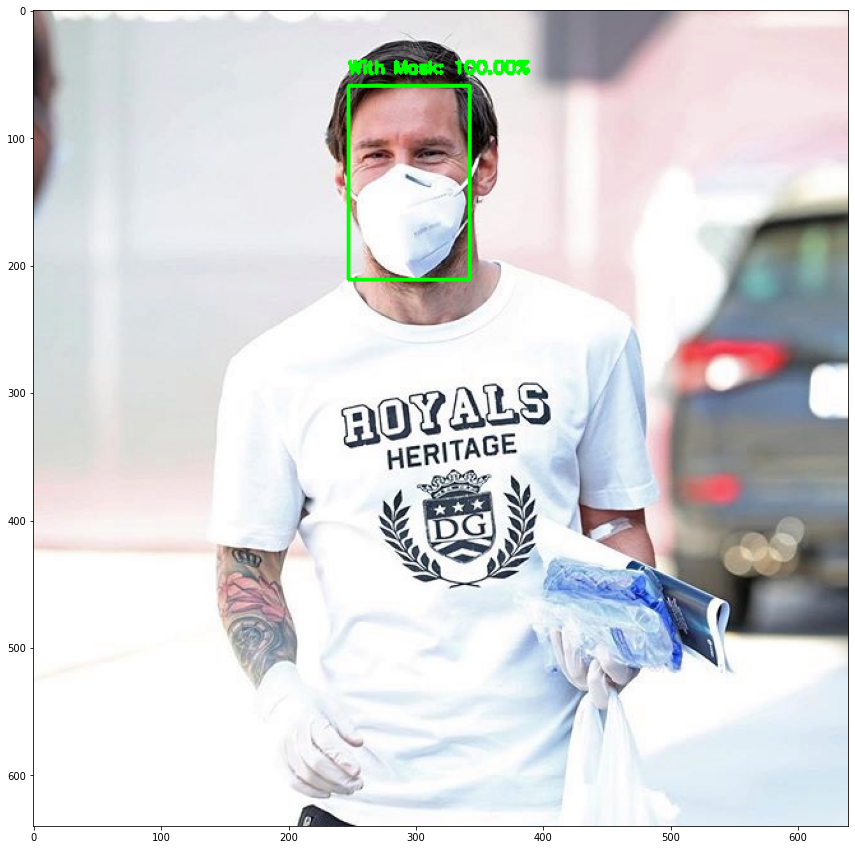

In [18]:
!wget --no-check-certificate \
    https://www.thesun.co.uk/wp-content/uploads/2020/05/95699602_665064597389461_1495603232396609764_njpg-JS581346883.jpg \
    -O ./image-1.jpg

image = mask_detector(face_detector, model, './image-1.jpg', 0.5)
plt.figure(figsize=(15, 15))
plt.imshow(image)

--2020-11-04 14:15:21--  https://resize.indiatvnews.com/en/resize/newbucket/715_-/2019/12/messi-ballon-d-or-1577270892.jpg
Resolving resize.indiatvnews.com (resize.indiatvnews.com)... 13.32.240.105, 13.32.240.75, 13.32.240.25, ...
Connecting to resize.indiatvnews.com (resize.indiatvnews.com)|13.32.240.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19418 (19K) [image/jpeg]
Saving to: ‘./image-2.jpg’

./image-2.jpg       100%[===================>]  18.96K  --.-KB/s    in 0s      

2020-11-04 14:15:21 (74.1 MB/s) - ‘./image-2.jpg’ saved [19418/19418]



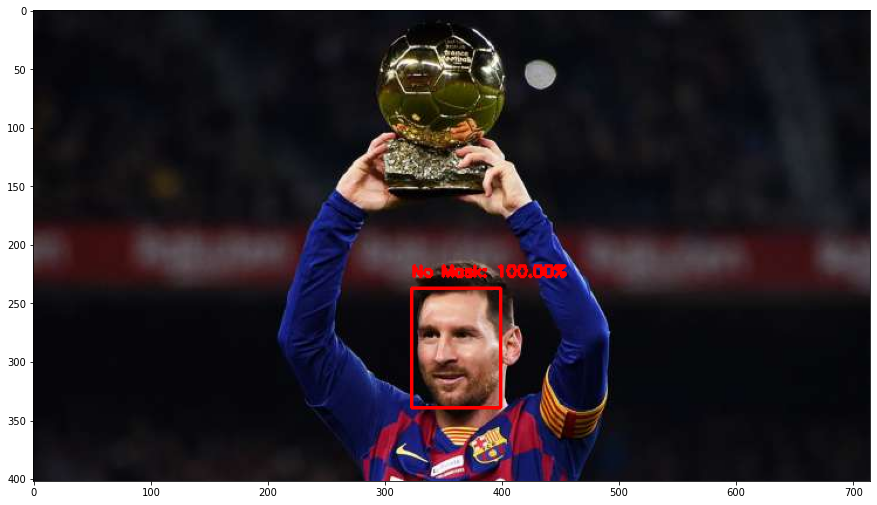

In [22]:
!wget --no-check-certificate \
    https://resize.indiatvnews.com/en/resize/newbucket/715_-/2019/12/messi-ballon-d-or-1577270892.jpg \
    -O ./image-2.jpg

image = mask_detector(face_detector, model, './image-2.jpg', 0.5)
plt.figure(figsize=(15, 15))
plt.imshow(image)

--2020-11-04 14:15:49--  https://cdni.rt.com/files/2020.05/xxl/5ecfdd3f85f5406e08625e82.jpg
Resolving cdni.rt.com (cdni.rt.com)... 92.223.58.254, 2a03:90c0:9997::9997
Connecting to cdni.rt.com (cdni.rt.com)|92.223.58.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140780 (137K) [image/jpeg]
Saving to: ‘./image-3.jpg’

./image-3.jpg       100%[===================>] 137.48K  --.-KB/s    in 0.1s    

2020-11-04 14:15:49 (987 KB/s) - ‘./image-3.jpg’ saved [140780/140780]



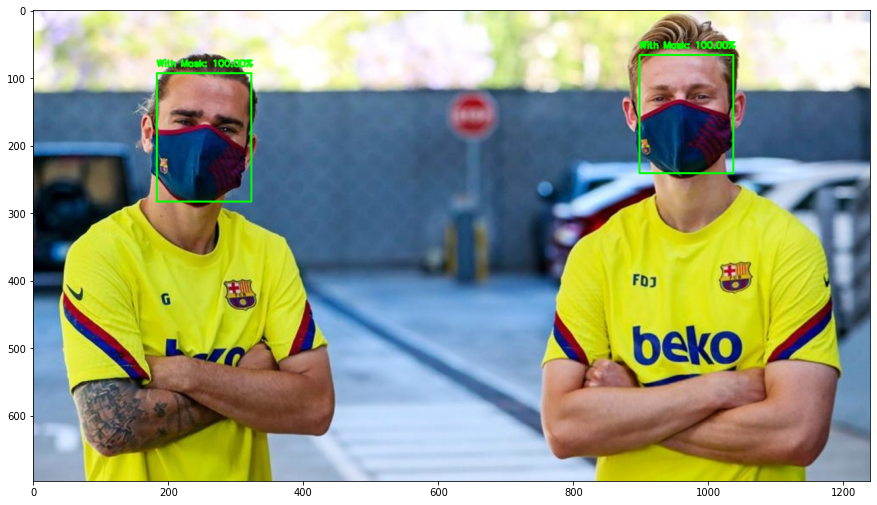

In [23]:
!wget --no-check-certificate \
    https://cdni.rt.com/files/2020.05/xxl/5ecfdd3f85f5406e08625e82.jpg \
    -O ./image-3.jpg

image = mask_detector(face_detector, model, './image-3.jpg', 0.5)
plt.figure(figsize=(15, 15))
plt.imshow(image)